In [1]:
from seq2seq.data.data_manager import Seq2SeqDataManager
from seq2seq.model.seq2seq_learner import Seq2seqLearner
import torch

To use this code, install requirements.txt packages, donwload spacy en and fr models (https://spacy.io/usage/models) and fasttext en and fr pretrained wordvectors (https://fasttext.cc/docs/en/crawl-vectors.html). Pretrained wordvectors are not in repository because of their size.

## Initialize data

In [2]:
MIN_LENGTH = 3 #min nr of tokens in sequence so that sequence is kept (otherwse removed) 
MAX_LENGTH = 15 #max nr of tokens in sequence so that sequence is kept (otherwse removed)
MIN_COUNT = 3 #min count of tokens so that it is not transformed to <unk>

#this tokenizes, prepocesses sequences so that learner could use it
data_manager = Seq2SeqDataManager.create_from_txt('data/eng-fra_sub.txt','en', 'en',
                                                  min_freq=MIN_COUNT, min_ntoks=MIN_LENGTH,
                                                  max_ntoks=MAX_LENGTH, switch_pair=True)

Creating training dataset
  Checking x sequence match to max, min criterias
    kept 1680 sequences from 1680 sequences
    kept 1680 sequences from 1680 sequences
  Checking y sequence match to max, min criterias
    kept 1680 sequences from 1680 sequences
    kept 1680 sequences from 1680 sequences
Creating valid dataset
  Checking x sequence match to max, min criterias
    kept 184 sequences from 184 sequences
    kept 184 sequences from 184 sequences
  Checking y sequence match to max, min criterias
    kept 184 sequences from 184 sequences
    kept 184 sequences from 184 sequences


In [3]:
train_dataloader, valid_dataloader=data_manager.get_dataloaders()
next(iter(train_dataloader))

(tensor([[ 25, 135,  25,  95,  41,   0,   0,   0,  96, 117],
         [  0, 163,   0,  29,   5,   5,   4,   5,   5,   5],
         [  5,   5,   5,   5,   3,   3,   3,   3,   3,   3],
         [  3,   3,   3,   3,   1,   1,   1,   1,   1,   1]]),
 tensor([4, 4, 4, 4, 3, 3, 3, 3, 3, 3]),
 tensor([[  0, 162,  74,  74,  14,  65,   0,  74,  48,  48],
         [  7,   7,   7,   7,   4,   7,   4,   7,   7,   7],
         [  3,   3,   3,   3,   3,   3,   3,   3,   3,   3]]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

## Load pretrained word vectors

In [4]:
data_manager.load_ft_vectors('data/wiki.en.vec', 'data/wiki.fr.vec')

# Initalize learner

In [5]:
hidden_size=300 #if adding pretrained wordvectors, this size must match with its size
learner=Seq2seqLearner(data_manager,hidden_size)

Encoder embedding vector didnt have 285 tokens, example ['!', 'je', 'suis', 'est', '?']
Decoder embedding vector didnt have 269 tokens, example ['i', 'it', '!', 'm', '?']


Learner is a subclass of torch nn.Module. We could see architecutre of our model:

In [6]:
learner

Seq2seqLearner(
  (encoder): EncoderRNN(
    (embedding): Embedding(285, 300, padding_idx=1)
    (gru): GRU(300, 300, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (decoder): LuongAttnDecoderRNN(
    (embedding): Embedding(269, 300, padding_idx=1)
    (embedding_dropout): Dropout(p=0.1)
    (gru): GRU(300, 300, num_layers=2, dropout=0.1)
    (concat): Linear(in_features=600, out_features=300, bias=True)
    (out): Linear(in_features=300, out_features=269, bias=True)
    (attn): Attn()
  )
)

# Train model

To train a model, I created method fit, which uses our batches from dataloader to train model.

0:0:25.31 (1 5.0%) loss train: 3.875 loss valid: 3.468
Input: je n y suis pas <unk> . <eos>
Target: i didn t go . <eos>


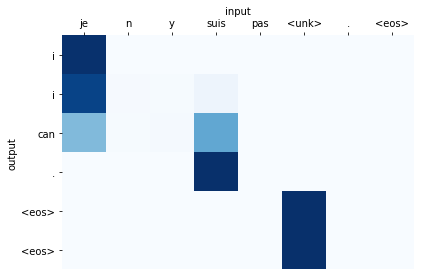

0:0:25.62 (2 10.0%) loss train: 3.108 loss valid: 2.461
0:0:25.82 (3 15.0%) loss train: 2.43 loss valid: 1.993
0:0:25.85 (4 20.0%) loss train: 2.039 loss valid: 1.93
0:0:26.0 (5 25.0%) loss train: 1.804 loss valid: 1.8
0:0:25.99 (6 30.0%) loss train: 1.659 loss valid: 1.571
Input: je n y suis pas <unk> . <eos>
Target: i didn t go . <eos>


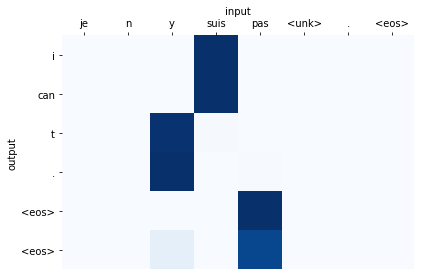

0:0:26.07 (7 35.0%) loss train: 1.389 loss valid: 1.506
0:0:26.1 (8 40.0%) loss train: 1.106 loss valid: 1.353
0:0:26.07 (9 45.0%) loss train: 0.949 loss valid: 1.303
0:0:26.07 (10 50.0%) loss train: 0.874 loss valid: 1.3
0:0:26.11 (11 55.0%) loss train: 0.77 loss valid: 1.256
Input: je n y suis pas <unk> . <eos>
Target: i didn t go . <eos>


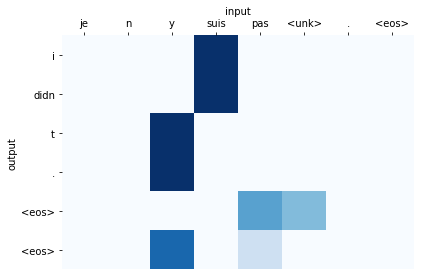

0:0:26.21 (12 60.0%) loss train: 0.635 loss valid: 1.196
0:0:26.3 (13 65.0%) loss train: 0.587 loss valid: 1.197
0:0:26.21 (14 70.0%) loss train: 0.526 loss valid: 1.193
0:0:26.23 (15 75.0%) loss train: 0.482 loss valid: 1.195
0:0:26.22 (16 80.0%) loss train: 0.44 loss valid: 1.205
Input: je n y suis pas <unk> . <eos>
Target: i didn t go . <eos>


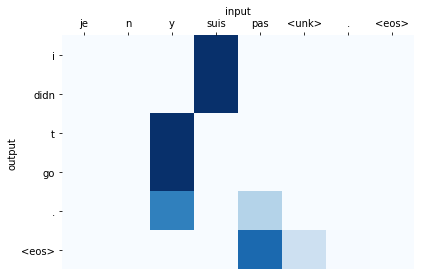

0:0:26.21 (17 85.0%) loss train: 0.461 loss valid: 1.197
0:0:26.23 (18 90.0%) loss train: 0.4 loss valid: 1.203
0:0:26.26 (19 95.0%) loss train: 0.361 loss valid: 1.212
0:0:26.31 (20 100.0%) loss train: 0.367 loss valid: 1.24


In [7]:
batch_size=100
learning_rate=0.001
learner.fit(20,learning_rate, show_attention_every=5, show_attention_idxs=[0], device='cuda')

## Predict

Example  prediction:

In [8]:
original_xtext = 'Je suis sûr.'
original_ytext = 'I am sure.'
predicted_text = learner.predict(original_xtext, device='cpu')
print(f'original text: {original_xtext}')
print(f'original answer: {original_ytext}')
print(f'predicted text: {predicted_text}')

original text: Je suis sûr.
original answer: I am sure.
predicted text: i m sure . <eos>


Change devices if needed:

In [9]:
original_xtext = 'Je suis sûr.'
original_ytext = 'I am sure.'
predicted_text = learner.predict(original_xtext, device='cuda')
print(f'original text: {original_xtext}')
print(f'original answer: {original_ytext}')
print(f'predicted text: {predicted_text}')

original text: Je suis sûr.
original answer: I am sure.
predicted text: i m sure . <eos>


## Save

Saving was supposed to be easy using nn.Module, but spacy tokenizer was having issues with pickling. So instead of torch.save(learner), we save internal state dict and data_manager separately.

In [10]:
data_manager.save('example_data_manager.pth')
torch.save(learner.state_dict(), 'example_state_dict.pth')

## Loading 

For loading we must first load dataloader, then initialize learner and load it's internal structure. Not very too pretty but does the job. If spacy tokenizer would not have an issues with pickling we could make it simpler. As purpose of this code is to be simple tutorial, I didn't want to see more trouble with it.

In [11]:
data_manager_new=Seq2SeqDataManager.load('example_data_manager.pth')

In [12]:
#not very nice solution, but works. Learner parameters should be saved and given input for loading learner
model=Seq2seqLearner(data_manager_new,hidden_size) #initialize learner object
model.load_state_dict(torch.load('example_state_dict.pth')) #load state dict

Encoder embedding vector didnt have 285 tokens, example ['!', 'je', 'suis', 'est', '?']
Decoder embedding vector didnt have 269 tokens, example ['i', 'it', '!', 'm', '?']


In [13]:
model

Seq2seqLearner(
  (encoder): EncoderRNN(
    (embedding): Embedding(285, 300, padding_idx=1)
    (gru): GRU(300, 300, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (decoder): LuongAttnDecoderRNN(
    (embedding): Embedding(269, 300, padding_idx=1)
    (embedding_dropout): Dropout(p=0.1)
    (gru): GRU(300, 300, num_layers=2, dropout=0.1)
    (concat): Linear(in_features=600, out_features=300, bias=True)
    (out): Linear(in_features=300, out_features=269, bias=True)
    (attn): Attn()
  )
)

In [14]:
#to check let's predict and see if we get same result
model.predict(original_xtext)

'i m sure . <eos>'